# Input Algebras

## Imports

In [1]:
import src.utils as utils

In [2]:
import ipynb.fs.full.x0_3_HDD as hdd

In [3]:
import ipynb.fs.full.x0_1_GrammarFuzzer as fuzzer

In [4]:
import ipynb.fs.full.x0_2_Parser as parser

In [5]:
from ipynb.fs.full.x0_3_HDD import PRes

In [6]:
import sympy

In [7]:
import random

In [8]:
random.seed(0)

In [9]:
import itertools as I

In [10]:
import ipynb.fs.full.x3_0_AbstractingInputs as abstractinginputs

<start> {'<term>', '<expr>', '<digit>', '<factor>', '<integer>'}
<expr> {'<term>', '<expr>', '<digit>', '<factor>', '<integer>'}
<term> {'<term>', '<expr>', '<digit>', '<factor>', '<integer>'}
<factor> {'<term>', '<expr>', '<digit>', '<factor>', '<integer>'}
<integer> {'<digit>', '<integer>'}
<digit> set()
{'<digit>', '<integer>'}
<start>
	 ['<expr>'] [0]
<expr>
	 ['<term>', '+', '<expr>'] [0, 2]
	 ['<term>', '-', '<expr>'] [0, 2]
	 ['<term>'] [0]
<term>
	 ['<factor>', '*', '<term>'] [0, 2]
	 ['<factor>', '/', '<term>'] [0, 2]
	 ['<factor>'] [0]
<factor>
	 ['+', '<factor>'] [1]
	 ['-', '<factor>'] [1]
	 ['(', '<expr>', ')'] [1]
	 ['<integer>', '.', '<integer>'] []
	 ['<integer>'] []
<integer>
	 ['<digit>', '<integer>'] []
	 ['<digit>'] []
<digit>
	 ['0'] []
	 ['1'] []
	 ['2'] []
	 ['3'] []
	 ['4'] []
	 ['5'] []
	 ['6'] []
	 ['7'] []
	 ['8'] []
	 ['9'] []
<start F1>
     ['<expr F1>']

<expr F1>
     ['<term F1>', '+', '<expr>']
     ['<term>', '+', '<expr F1>']
     ['<term F1>', '-', 

## Expression Grammar

In [11]:
import sympy

Our language is a simple language of boolean algebra. That is, it is the
language of expressions in the specialization for a nonterminal such as `<A and(f1,f2)>`
It is defined by the following grammar.

In [12]:
import string

BEXPR_GRAMMAR = {
    '<start>': [['<bexpr>']],
    '<bexpr>': [
        ['<bop>', '(', '<bexprs>', ')'],
        ['<fault>']],
    '<bexprs>' : [['<bexpr>', ',', '<bexprs>'], ['<bexpr>']],
    '<bop>' : [list('and'), list('or'), list('neg')],
    '<fault>': [['<letters>'], []],
    '<letters>': [
        ['<letter>'],
        ['<letter>', '<letters>']],
    '<letter>': [[i] for i in (
        string.ascii_lowercase +
        string.ascii_uppercase +
        string.digits) + '_+*.-']
}
BEXPR_START = '<start>'

Next, we need a data structure to represent the boolean language.
First we represent our literals using `LitB` class.

In [13]:
class LitB:
    def __init__(self, a): self.a = a
    def __str__(self): return self.a

There are two boolean literals. The top and the bottom. The top literal
also (T) essentially indicates that there is no specialization of the base
nonterminal. For e.g. `<A>` is a top literal.
Hence, we indicate it by an empty string.

In [14]:
TrueB = LitB('')

The bottom literal indicates that there are no possible members for this
particular nonterminal. For e.g. <A _|_> indicates that this is empty.
We indicate it by the empty symbol _|_.

In [15]:
FalseB = LitB('_|_')

Next, we define the standard terms of the boolean algebra. `or(.,.)`, `and(.,.)` and `neg(.)`

In [16]:
class OrB:
    def __init__(self, a): self.l = a
    def __str__(self): return 'or(%s)' % ','.join(sorted([str(s) for s in self.l]))
class AndB:
    def __init__(self, a): self.l = a
    def __str__(self): return 'and(%s)' % ','.join(sorted([str(s) for s in self.l]))
class NegB:
    def __init__(self, a): self.a = a
    def __str__(self): return 'neg(%s)' % str(self.a)
class BLit:
    def __init__(self, a): self.a = a
    def __str__(self): return str(self.a)

We then come to the actual representative class. The class is initialized by
providing it with a boolean expression.

In [17]:
class BExpr:
    def __init__(self, s):
        if s is not None:
            self._s = s
            self._tree = self._parse(s)
            self._simple, self._sympy = self._simplify()
        else: # create
            self._s = None
            self._tree = None
            self._simple = None
            self._sympy = None

    def _parse(self, k):
        bexpr_parser = parser.EarleyParser(BEXPR_GRAMMAR)
        bparse_tree = list(bexpr_parser.parse_on(k, start_symbol=BEXPR_START))[0]
        bexpr = bparse_tree[1][0]
        return bexpr

    def _simplify(self):
        return None,None

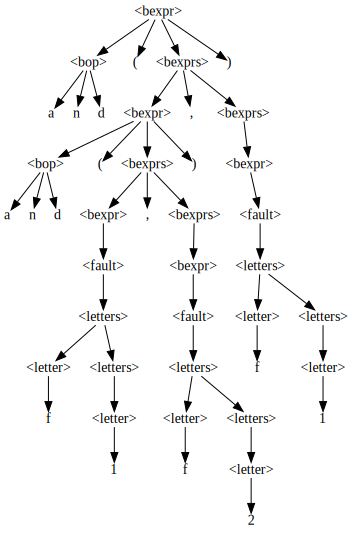

In [18]:
b = BExpr('and(and(f1,f2),f1)')
utils.display_tree(b._tree)

Now, we need to define how to simplify boolean expressions. For example,
we want to simplify `and(and(f1,f2),f1)` to just `and(f1,f2)`. Since this
is already offered by `sympy` we use that.

First we define a procedure that given the parse tree, converts it to a sympy
expression.

In [19]:
class BExpr(BExpr):
    def _convert_to_sympy(self, bexpr_tree, symargs=None):
        def get_op(node):
            assert node[0] == '<bop>', node[0]
            return ''.join([i[0] for i in node[1]])
        if symargs is None:
            symargs = {}
        name, children = bexpr_tree
        assert name == '<bexpr>', name
        if len(children) == 1: # fault node
            name = utils.tree_to_str(children[0])
            if not name: return None, symargs
            if name not in symargs:
                symargs[name] = sympy.symbols(name)
            return symargs[name], symargs
        else:
            operator = get_op(children[0])
            if operator == 'and':
                if children[2][0] == '<bexprs>':
                    res = self._flatten(children[2])
                else:
                    res = [children[2]]
                sp = [self._convert_to_sympy(a, symargs) for a in res]
                return sympy.And(*[a for a,_ in sp]), symargs

            elif operator == 'or':
                if children[2][0] == '<bexprs>':
                    res = self._flatten(children[2])
                else:
                    res = [children[2]]
                sp = [self._convert_to_sympy(a, symargs) for a in res]
                return sympy.Or(*[a for a,_ in sp]), symargs

            elif operator == 'neg':
                if children[2][0] == '<bexprs>':
                    res = self._flatten(children[2])
                else:
                    res = [children[2]]
                assert len(res) == 1
                a,_ = self._convert_to_sympy(res[0], symargs)
                return sympy.Not(a), symargs
            else:
                assert False

    def _flatten(self, bexprs):
        assert bexprs[0] == '<bexprs>'
        if len(bexprs[1]) == 1:
            return [bexprs[1][0]]
        else:
            assert len(bexprs[1]) == 3
            a = bexprs[1][0]
            comma = bexprs[1][1]
            rest = bexprs[1][2]
            return [a] + self._flatten(rest)

Next, we define the reverse. Given the `sympy` expression, we define a
procedure to convert it to the boolean data-structure.

In [20]:
class BExpr(BExpr):
    def _convert_sympy_to_bexpr(self, sexpr, log=False):
        if isinstance(sexpr, sympy.Symbol):
            return BLit(str(sexpr))
        elif isinstance(sexpr, sympy.Not):
            return NegB(self._convert_sympy_to_bexpr(sexpr.args[0]))
        elif isinstance(sexpr, sympy.And):
            a = sexpr.args[0]
            b = sexpr.args[1]
            if isinstance(a, sympy.Not):
                if str(a.args[0]) == str(b): return FalseB # F & ~F == _|_
            elif isinstance(b, sympy.Not):
                if str(b.args[0]) == str(a): return FalseB # F & ~F == _|_
            sym_vars = sorted([self._convert_sympy_to_bexpr(a) for a in sexpr.args], key=str)
            assert sym_vars
            if FalseB in sym_vars: return FalseB # if bottom is present in and, that is the result
            if TrueB in sym_vars:
                sym_vars = [s for s in sym_vars if s != TrueB] # base def does not do anything in and.
                if not sym_vars: return TrueB
            return AndB(sym_vars)
        elif isinstance(sexpr, sympy.Or):
            a = sexpr.args[0]
            b = sexpr.args[1]
            if isinstance(a, sympy.Not):
                if str(a.args[0]) == str(b): return TrueB # F | ~F = U self._convert_sympy_to_bexpr(b)
            elif isinstance(b, sympy.Not):
                if str(b.args[0]) == str(a): return TrueB # F | ~F = U self._convert_sympy_to_bexpr(a)

            sym_vars = sorted([self._convert_sympy_to_bexpr(a) for a in sexpr.args], key=str)
            assert sym_vars
            if TrueB in sym_vars: return TrueB # if original def is present in or, that is the result
            if FalseB in sym_vars:
                sym_vars = [s for s in sym_vars if s != FalseB]
                if not sym_vars: return FalseB
            return OrB(sym_vars)
        else:
            if log: print(repr(sexpr))
            assert False

Finally, we stitch them together.

In [21]:
class BExpr(BExpr):
    def simple(self):
        if self._simple is None:
            self._simple = str(self._convert_sympy_to_bexpr(self._sympy))
        return self._simple

    def _simplify(self):
        e0, defs = self._convert_to_sympy(self._tree)
        e1 = sympy.to_dnf(e0)
        e2 = self._convert_sympy_to_bexpr(e1)
        v = str(e2)
        my_keys = [k for k in defs]
        for k in my_keys:
            del defs[k]
        return v, e1

In [22]:
b = BExpr('and(and(f1,f2),f1)')
print(b.simple())

and(f1,f2)


We now need to come to one of the main reasons for the existence of
this class. In later posts, we will see that we will need to
recreate a given nonterminal given the basic building blocks, and
the boolean expression of the nonterminal. So, what we will do is
to first parse the boolean expression using `BExpr`, then use
`sympy` to simplify (as we have shown above), then unwrap the
`sympy` one layer at a time, noting the operator used. When we
come to the faults (or their negations) themselves, we return
back from negation with their definitions from the original grammars,
and as we return from each layer, we reconstruct the required
expression from the given nonterminal definitions (or newly built ones)>

The `get_operator()` returns the
outer operator, `op_fst()` returns the first operator if the
operator was a negation (and throws exception if it is used
otherwise, and `op_fst_snd()` returns the first and second
parameters for the outer `and` or `or`.

In [23]:
class BExpr(BExpr):
    def get_operator(self):
        if isinstance(self._sympy, sympy.And): return 'and'
        elif isinstance(self._sympy, sympy.Or): return 'or'
        elif isinstance(self._sympy, sympy.Not): return 'neg'
        else: return ''

    def op_fst(self):
        op = self.get_operator()
        assert op == 'neg'
        bexpr = BExpr(None)
        bexpr._sympy = self._sympy.args[0]
        return bexpr

    def op_fst_snd(self):
        bexpr = BExpr(None)
        bexpr._sympy = self._sympy.args[0]

        bexpr_rest = BExpr(None)
        op = self.get_operator()

        if op == 'and':
            bexpr_rest._sympy = sympy.And(*self._sympy.args[1:])
        elif op == 'or':
            bexpr_rest._sympy = sympy.Or(*self._sympy.args[1:])
        else:
            assert False
        return bexpr, bexpr_rest

We also define two convenience functions.

In [24]:
class BExpr(BExpr):
    def with_key(self, k):
        s = self.simple()
        if s:
            return '<%s %s>' % (stem(k), s)
        else:
            # this bexpr does not contain an expression.
            # So return the basic key
            return normalize(k)

    def negate(self):
        bexpr = BExpr(None)
        bexpr._sympy = sympy.Not(self._sympy).simplify()
        return bexpr

Next, given a grammar, we need to find all undefined nonterminals that
we need to reconstruct. This is done as follows.

In [25]:
def find_all_nonterminals(g):
    lst = []
    for k in g:
        for r in g[k]:
            for t in r:
                if utils.is_nt(t):
                    lst.append(t)
    return list(sorted(set(lst)))

def undefined_keys(grammar):
    keys = find_all_nonterminals(grammar)
    return [k for k in keys if k not in grammar]

In [26]:
EXPR_GRAMMAR = {
 '<start>': [['<expr>']],
 '<expr>': [['<term>', '+', '<expr>'],
            ['<term>', '-', '<expr>'],
            ['<term>']],
 '<term>': [['<factor>', '*', '<term>'],
            ['<factor>', '/', '<term>'],
            ['<factor>']],
 '<factor>': [['+', '<factor>'],
              ['-', '<factor>'],
              ['(', '<expr>', ')'],
              ['<integer>', '.', '<integer>'],
              ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'], ['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'], ['9']]}

EXPR_START = '<start>'

In [27]:
EXPR_DPAREN_S = '<start D1>'
EXPR_DPAREN_G = {
        '<start>': [['<expr>']],
        '<expr>': [['<term>', '+', '<expr>'], ['<term>', '-', '<expr>'], ['<term>']],
        '<term>': [['<factor>', '*', '<term>'], ['<factor>', '/', '<term>'], ['<factor>']],
        '<factor>': [['+', '<factor>'], ['-', '<factor>'], ['(', '<expr>', ')'], ['<integer>', '.', '<integer>'], ['<integer>']],
        '<integer>': [['<digit>', '<integer>'], ['<digit>']],
        '<digit>': [['0'], ['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'], ['9']],
        '<factor D1_0>': [['(', '<expr D1_1>', ')']],
        '<expr D1_1>': [['<term D1_2>']],
        '<term D1_2>': [['<factor D1_3>']],
        '<factor D1_3>': [['(', '<expr>', ')']],
        '<start D1>': [['<expr D1>']],
        '<expr D1>': [['<term D1>', '+', '<expr>'], ['<term>', '+', '<expr D1>'], ['<term D1>', '-', '<expr>'], ['<term>', '-', '<expr D1>'], ['<term D1>']],
        '<term D1>': [['<factor D1>', '*', '<term>'], ['<factor>', '*', '<term D1>'], ['<factor D1>', '/', '<term>'], ['<factor>', '/', '<term D1>'], ['<factor D1>']],
        '<factor D1>': [['+', '<factor D1>'], ['-', '<factor D1>'], ['(', '<expr D1>', ')'], ['(', '<expr D1_1>', ')']]
} 

In [28]:
EXPR_DZERO_S = '<start Z1>'
EXPR_DZERO_G = {
        '<start>': [['<expr>']],
        '<expr>': [['<term>', '+', '<expr>'], ['<term>', '-', '<expr>'], ['<term>']],
        '<term>': [['<factor>', '*', '<term>'], ['<factor>', '/', '<term>'], ['<factor>']],
        '<factor>': [['+', '<factor>'], ['-', '<factor>'], ['(', '<expr>', ')'], ['<integer>', '.', '<integer>'], ['<integer>']],
        '<integer>': [['<digit>', '<integer>'], ['<digit>']],
        '<digit>': [['0'], ['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'], ['9']],
        '<term Z1_0>': [['<factor>', '/', '<term Z1_1>']],
        '<term Z1_1>': [['<factor Z1_2>']],
        '<factor Z1_2>': [['<integer Z1_3>']],
        '<integer Z1_3>': [['<digit Z1_4>']],
        '<digit Z1_4>': [['0']],
        '<start Z1>': [['<expr Z1>']],
        '<expr Z1>': [['<term Z1>', '+', '<expr>'], ['<term>', '+', '<expr Z1>'], ['<term Z1>', '-', '<expr>'], ['<term>', '-', '<expr Z1>'], ['<term Z1>']],
        '<term Z1>': [['<factor Z1>', '*', '<term>'], ['<factor>', '*', '<term Z1>'], ['<factor Z1>', '/', '<term>'], ['<factor>', '/', '<term Z1>'], ['<factor Z1>'], ['<factor>', '/', '<term Z1_1>']],
        '<factor Z1>': [['+', '<factor Z1>'], ['-', '<factor Z1>'], ['(', '<expr Z1>', ')']]
}

In [29]:
grammar ={**EXPR_DZERO_G, **EXPR_DPAREN_G, **{'<start and(D1,Z1)>': [['<expr and(D1,Z1)>']]}}
keys = undefined_keys(grammar)
print(keys)

['<expr and(D1,Z1)>']


In [30]:
def tsplit(token):
    assert token[0], token[-1] == ('<', '>')
    front, *back = token[1:-1].split(None, 1)
    return front, ' '.join(back)

def refinement(token):
    return tsplit(token)[1].strip()

def is_refined_key(key):
    assert utils.is_nt(key)
    return (' ' in key)

def is_base_key(key):
    return not is_refined_key(key)

def stem(token):
    return tsplit(token)[0].strip()

def normalize(token):
    assert utils.is_nt(token), token
    if is_base_key(token): return token
    return '<%s>' % stem(token)

def refine_base_key(k, prefix):
    assert utils.is_nt(k), k
    assert is_base_key(k), k
    return '<%s %s>' % (stem(k), prefix)

## And Grammars
Now, we want to combine these grammars. Remember that a gramamr has a set of
definitions that correspond to nonterminals, and each definition has a set of
rules. We start from the rules. If we want to combine two grammars, we need
to make sure that any input produced from the combined grammar is also parsed
by the original grammars. That is, any rule from the combined grammar should
have a corresponding rule in the original grammars. This gives us the
algorithm for combining two rules. First, we can only combine rules that have
similar base representation. That is, if ruleA is `[<A f1>, <B f2>, 'T']` 
where `<A>` and `<B>` are nonterminals and `T` is a terminal
and ruleB is `[<A f1>, <C f3>]`, these can't have a combination in the
combined grammar. On the other hand, if ruleB is `[<A f3>, <B f4> 'T']`
then, a combined rule of `[<A f1 & f3>, <B f2 & f4>, 'T']` can infact
represent both parent rules. That is, when combining two rules from different,
grammars, their combination is empty if they have different base
representation.

The idea for combining two definitions of nonterminals is simply using the
distributive law. A definition is simply # `A1 or B1 or C1` where `A1` etc are
rules. Now, when you want to and two defintions, you have
`and(A1 or B1 or C1, A2 or B2 or C2)` , and you want the `or` out again.
So, this becomes

```
(A1 AND A2) OR (A1 AND B2) OR (A1 AND C2) OR
(A2 AND B1) OR (A2 AND C1) OR
(B1 AND B2) OR (B1 AND C2) OR
(B2 AND C1) OR (C1 AND C2)
```

which is essentially that many rules.

### Combining tokens
If they have the same base representation, then we only have to deal with how
to combine the nonterminal symbols. The terminal symbols are exactly the same
in parent rules as well as combined rule. So, given two tokens, we can
combine them as follows. The `and` of a refined nonterminal and a base
nonterminal is always the refined nonterminal. Otherwise, it is simply an
`and()` specialization of both refinements.

In [31]:
def and_nonterminals(k1, k2):
    b1, s1 = tsplit(k1)
    b2, s2 = tsplit(k2)
    assert b1 == b2
    if not s1: return k2
    if not s2: return k1
    if s1 == s2: return k1
    return '<%s and(%s,%s)>' % (b1, s1, s2)

def and_tokens(t1, t2):
    if not utils.is_nt(t1): return t1
    return and_nonterminals(t1, t2)

In [32]:
print(and_tokens('C', 'C'))
print(and_tokens('<A>', '<A f1>'))
print(and_tokens('<A f2>', '<A f1>'))

C
<A f1>
<A and(f2,f1)>


## Combining rules
Next, we define combination for rules

In [33]:
def and_rules(ruleA, ruleB):
    AandB_rule = []
    for t1,t2 in zip(ruleA, ruleB):
        AandB_rule.append(and_tokens(t1, t2))
    return AandB_rule

In [34]:
print(and_rules(['<A>', '<B f1>', 'C'], ['<A f1>', '<B>', 'C']))
print(and_rules(['<A f2>', '<B f1>', 'C'], ['<A f1>', '<B f3>', 'C']))
print(and_rules(['<A f1>', '<B f1>', 'C'], ['<A f1>', '<B f3>', 'C']))

['<A f1>', '<B f1>', 'C']
['<A and(f2,f1)>', '<B and(f1,f3)>', 'C']
['<A f1>', '<B and(f1,f3)>', 'C']


### Combining rulesets

Next, our grammars may contain multiple rules that represent the same base
rule. All the rules that represent the same base rule is called a ruleset.
combining two rulesets is done by producing a new ruleset that contains all
possible pairs of rules from the parent ruleset.


In [35]:
def and_ruleset(rulesetA, rulesetB):
    rules = []
    for ruleA,ruleB in I.product(rulesetA, rulesetB):
        AandB_rule = and_rules(ruleA, ruleB)
        rules.append(AandB_rule)
    return rules

In [36]:
A = [['<A>', '<B f1>', 'C'], ['<A f1>', '<B>', 'C']]
B = [['<A f2>', '<B f1>', 'C'], ['<A f1>', '<B f3>', 'C']]
C = [['<A f1>', '<B f1>', 'C'], ['<A f1>', '<B f3>', 'C']]

In [37]:
for k in and_ruleset(A, B): print(k)
print()
for k in and_ruleset(A, C): print(k)
print()
for k in and_ruleset(B, C): print(k)
print()

['<A f2>', '<B f1>', 'C']
['<A f1>', '<B and(f1,f3)>', 'C']
['<A and(f1,f2)>', '<B f1>', 'C']
['<A f1>', '<B f3>', 'C']

['<A f1>', '<B f1>', 'C']
['<A f1>', '<B and(f1,f3)>', 'C']
['<A f1>', '<B f1>', 'C']
['<A f1>', '<B f3>', 'C']

['<A and(f2,f1)>', '<B f1>', 'C']
['<A and(f2,f1)>', '<B and(f1,f3)>', 'C']
['<A f1>', '<B and(f3,f1)>', 'C']
['<A f1>', '<B f3>', 'C']



Next, we define a few helper functions that collects all rulesets

In [38]:
def normalize(key):
    if is_base_key(key): return key
    return '<%s>' % stem(key)

def normalize_grammar(g):
    return {normalize(k):list({tuple([normalize(t) if utils.is_nt(t) else t for t in r]) for r in g[k]}) for k in g}

def rule_to_normalized_rule(rule):
    return [normalize(t) if utils.is_nt(t) else t for t in rule]

def normalized_rule_match(r1, r2):
    return rule_to_normalized_rule(r1) == rule_to_normalized_rule(r2)

def rule_normalized_difference(rulesA, rulesB):
    rem_rulesA = rulesA
    for ruleB in rulesB:
        rem_rulesA = [rA for rA in rem_rulesA if not normalized_rule_match(rA, ruleB)]
    return rem_rulesA

def get_rulesets(rules):
    rulesets = {}
    for rule in rules:
        nr = tuple(rule_to_normalized_rule(rule))
        if nr not in rulesets: rulesets[nr] = []
        rulesets[nr].append(rule)
    return rulesets

### definition conjunction
Now, we can define the conjunction of definitions as follows.

In [39]:
def and_definitions(rulesA, rulesB):
    AandB_rules = []
    rulesetsA, rulesetsB = get_rulesets(rulesA), get_rulesets(rulesB)
    # drop any rules that are not there in both.
    keys = set(rulesetsA.keys()) & set(rulesetsB.keys())
    for k in keys:
        new_rules = and_ruleset(rulesetsA[k], rulesetsB[k])
        AandB_rules.extend(new_rules)
    return AandB_rules

In [40]:
expr1 = [r for k in EXPR_DPAREN_G if 'expr' in k for r in EXPR_DPAREN_G[k]]
expr2 = [r for k in EXPR_DZERO_G if 'expr' in k for r in EXPR_DZERO_G[k]]
for k in and_definitions(expr1, expr2):
    print(k)
print()

['<term>', '-', '<expr>']
['<term Z1>', '-', '<expr>']
['<term>', '-', '<expr Z1>']
['<term D1>', '-', '<expr>']
['<term and(D1,Z1)>', '-', '<expr>']
['<term D1>', '-', '<expr Z1>']
['<term>', '-', '<expr D1>']
['<term Z1>', '-', '<expr D1>']
['<term>', '-', '<expr and(D1,Z1)>']
['<term>', '+', '<expr>']
['<term Z1>', '+', '<expr>']
['<term>', '+', '<expr Z1>']
['<term D1>', '+', '<expr>']
['<term and(D1,Z1)>', '+', '<expr>']
['<term D1>', '+', '<expr Z1>']
['<term>', '+', '<expr D1>']
['<term Z1>', '+', '<expr D1>']
['<term>', '+', '<expr and(D1,Z1)>']
['<term>']
['<term Z1>']
['<term D1_2>']
['<term and(D1_2,Z1)>']
['<term D1>']
['<term and(D1,Z1)>']



### grammar conjunction
We can now define our grammar conjunction as follows.

In [41]:
def and_grammars_(g1, s1, g2, s2):
    g1_keys = g1.keys()
    g2_keys = g2.keys()
    g = {**g1, **g2}
    for k1,k2 in I.product(g1_keys, g2_keys):
        if normalize(k1) != normalize(k2): continue
        and_key = and_tokens(k1, k2)
        g[and_key] = and_definitions(g1[k1], g2[k2])
    return g, and_tokens(s1, s2)

In [42]:
combined_g, combined_s = utils.grammar_gc(*and_grammars_(EXPR_DPAREN_G, EXPR_DPAREN_S, EXPR_DZERO_G, EXPR_DZERO_S))
utils.display_grammar(combined_g, combined_s)

[start]: <start and(D1,Z1)>
<start and(D1,Z1)> ::=
|   <expr and(D1,Z1)>
<expr and(D1,Z1)> ::=
|   <term and(D1,Z1)> '-' <expr>
|   <term D1> '-' <expr Z1>
|   <term Z1> '-' <expr D1>
|   <term> '-' <expr and(D1,Z1)>
|   <term and(D1,Z1)> '+' <expr>
|   <term D1> '+' <expr Z1>
|   <term Z1> '+' <expr D1>
|   <term> '+' <expr and(D1,Z1)>
|   <term and(D1,Z1)>
<term D1> ::=
|   <factor D1> '*' <term>
|   <factor> '*' <term D1>
|   <factor D1>
|   <factor D1> '/' <term>
|   <factor> '/' <term D1>
<expr Z1> ::=
|   <term Z1> '-' <expr>
|   <term> '-' <expr Z1>
|   <term Z1> '+' <expr>
|   <term> '+' <expr Z1>
|   <term Z1>
<term Z1> ::=
|   <factor Z1> '*' <term>
|   <factor> '*' <term Z1>
|   <factor Z1>
|   <factor Z1> '/' <term>
|   <factor> '/' <term Z1>
|   <factor> '/' <term Z1_1>
<expr D1> ::=
|   <term D1> '-' <expr>
|   <term> '-' <expr D1>
|   <term D1> '+' <expr>
|   <term> '+' <expr D1>
|   <term D1>
<term and(D1,Z1)> ::=
|   <factor and(D1,Z1)> '*' <term>
|   <factor D1> '*' <

This grammar is now guaranteed to produce instances of both characterizing
subtrees.

In [43]:
import re

In [44]:
def expr_div_by_zero(input_str):
    if '/0)' in input_str: return hdd.PRes.success
    else: return hdd.PRes.failed

In [45]:
def expr_double_paren(inp):
    if re.match(r'.*[(][(].*[)][)].*', inp):
        return PRes.success
    return PRes.failed

In [46]:
combined_f = fuzzer.LimitFuzzer(combined_g)
for i in range(10):
    v = combined_f.iter_gen_key(key=combined_s, max_depth=10)
    s = utils.tree_to_str(v)
    assert expr_div_by_zero(s)
    assert expr_double_paren(s)
    print(v)

['<start and(D1,Z1)>', [['<expr and(D1,Z1)>', [['<term>', [['<factor>', [['(', []], ['<expr>', [['<term>', [['<factor>', [['<integer>', [['<digit>', [['6', []]]]]], ['.', []], ['<integer>', [['<digit>', [['1', []]]]]]]], ['/', []], ['<term>', [['<factor>', [['+', []], ['<factor>', [['<integer>', [['<digit>', [['2', []]]]]], ['.', []], ['<integer>', [['<digit>', [['7', []]]]]]]]]], ['/', []], ['<term>', [['<factor>', [['(', []], ['<expr>', [['<term>', [['<factor>', [['<integer>', [['<digit>', [['5', []]]]]]]]]]]], [')', []]]], ['/', []], ['<term>', [['<factor>', [['<integer>', [['<digit>', [['1', []]]]]], ['.', []], ['<integer>', [['<digit>', [['6', []]]]]]]], ['*', []], ['<term>', [['<factor>', [['<integer>', [['<digit>', [['6', []]]]]], ['.', []], ['<integer>', [['<digit>', [['4', []]]]]]]]]]]]]]]]]], ['-', []], ['<expr>', [['<term>', [['<factor>', [['(', []], ['<expr>', [['<term>', [['<factor>', [['<integer>', [['<digit>', [['6', []]]]]]]], ['*', []], ['<term>', [['<factor>', [['<int

## Producing inputs with at least one of the two fault inducing fragments guaranteed to be present.
How do we construct grammars that are guaranteed to contain at least one of
the evocative patterns? This is actually much less complicated than `and`

The idea is simply using the distributive law. A definition is simply
`A1 or B1 or C1` as before where `A1` etc are rules.
Now, when you want to `or` two definitions, you have
`or(A1 or B1 or C1, A2 or B2 or C2)`, then it simply becomes
`A1 or B1 or C1 or A2 or B2 or C2`
At this point, our work is essentially done. All that we need to do
is to merge any rules that potentially allow us to merge. However, this
is not compulsory.

### Nonterminals
For nonterminals, it is similar to `and` except that the base cases differ.
`or` of a base nonterminal with a refined nonterminal is always the base.

In [47]:
def or_nonterminals(k1, k2):
    b1, s1 = tsplit(k1)
    b2, s2 = tsplit(k2)
    assert b1 == b2
    if not s1: return k1
    if not s2: return k2
    if s1 == s2: return k1
    return '<%s or(%s,%s)>' % (b1, s1, s2)

def or_tokens(t1, t2):
    if not utils.is_nt(t1): return t1
    return or_nonterminals(t1, t2)

## rules
What rules can be merged? Only those rules can be merged that has
a single refinement difference. That is if we have
`or(<A 1> <B 5> <C>, <A 2> <B 5> <C>)`, then this merges to
`<A or(1,2)><B 5><C>`. However `or(<A 1> <B 5> <C>, <A 2> <B 6> <C>)`
is not mergeable.

In [48]:
def or_rules(ruleA, ruleB, merge_with_or=True):
    pos = []
    for i,(t1,t2) in enumerate(zip(ruleA, ruleB)):
        if t1 == t2: continue
        else: pos.append(i)
    if len(pos) == 0: return [ruleA]
    elif len(pos) == 1:
        result = [[or_tokens(ruleA[i], ruleB[i]) if i == pos[0] else t
                for i,t in enumerate(ruleA)]]
        if merge_with_or: return result
        # if what we have at pos[0] is a base key, then we return the
        # rule. else we do not.
        merged = result[0][pos[0]]
        if is_base_key(merged):
            return result
        else:
            return [ruleA, ruleB]
    else: return [ruleA, ruleB]

In [49]:
a1 = ['<A 1>', '<B>','<C>']
a2 = ['<A 2>', '<B>','<C>']
for r in or_rules(a1, a2): print(r)
print()
a3 = ['<A 1>', '<B 2>','<C>']
a4 = ['<A 1>', '<B 3>','<C>']
for r in or_rules(a3, a4): print(r)
print()
a5 = ['<A 1>', '<B 2>','<C 3>']
a6 = ['<A 1>', '<B 3>','<C>']
for r in or_rules(a5, a6): print(r)
print()

['<A or(1,2)>', '<B>', '<C>']

['<A 1>', '<B or(2,3)>', '<C>']

['<A 1>', '<B 2>', '<C 3>']
['<A 1>', '<B 3>', '<C>']



## rulesets
For `or` rulesets we first combine
both rulesets together then (optional) take one at a time,
and check if it can be merged with another.

In [50]:
def or_ruleset(rulesetA, rulesetB, merge_with_or=True):
    rule,*rules = (rulesetA + rulesetB)
    current_rules = [rule]
    while rules:
        rule,*rules = rules
        new_rules = []
        modified = False
        for i,r in enumerate(current_rules):
            v =  or_rules(r, rule, merge_with_or)
            if len(v) == 1:
                current_rules[i] = v[0]
                rule = None
                break
            else:
                continue
        if rule is not None:
            current_rules.append(rule)
    return current_rules

In [51]:
A = [['<A>', '<B f1>', 'C'], ['<A f1>', '<B>', 'C']]
B = [['<A>', '<B f2>', 'C'], ['<A f1>', '<B f3>', 'C']]
for k in or_ruleset(A, B): print(k)
print()

['<A>', '<B or(f1,f2)>', 'C']
['<A f1>', '<B>', 'C']



### definition disjunction
Now, we can define the disjunction of definitions as follows.

In [52]:
def or_definitions(rulesA, rulesB, merge_with_or=True):
    AorB_rules = []
    rulesetsA, rulesetsB = get_rulesets(rulesA), get_rulesets(rulesB)
    keys = set(rulesetsA.keys()) | set(rulesetsB.keys())
    for k in keys:
        new_rules = or_ruleset(rulesetsA.get(k, []), rulesetsB.get(k, []), merge_with_or)
        AorB_rules.extend(new_rules)
    return AorB_rules

In [53]:
expr1 = [r for k in EXPR_DPAREN_G if 'expr' in k for r in EXPR_DPAREN_G[k]]
expr2 = [r for k in EXPR_DZERO_G if 'expr' in k for r in EXPR_DZERO_G[k]]
for k in or_definitions(expr1, expr2):
    print(k)
print()

['<term>', '-', '<expr>']
['<term>', '+', '<expr>']
['<term>']



### grammar disjunction

In [54]:
def or_grammars_(g1, s1, g2, s2):
    g = {}
    # now get the matching keys for each pair.
    for k in list(g1.keys()) + list(g2.keys()): 
         g[k] = [[t for t in r] for r in list(set([tuple(k) for k in (g1.get(k, []) + g2.get(k, []))]))]
    
    # We do not actually need to use merging of rule_sets for disjunction.
    s_or = or_nonterminals(s1, s2)
    g[s_or] = g1[s1] + g2[s2]
    return g, s_or

In [55]:
or_g, or_s = utils.grammar_gc(*or_grammars_(EXPR_DPAREN_G, EXPR_DPAREN_S, EXPR_DZERO_G, EXPR_DZERO_S))
utils.display_grammar(or_g, or_s)

[start]: <start or(D1,Z1)>
<start or(D1,Z1)> ::=
|   <expr D1>
|   <expr Z1>
<expr D1> ::=
|   <term> '-' <expr D1>
|   <term> '+' <expr D1>
|   <term D1>
|   <term D1> '-' <expr>
|   <term D1> '+' <expr>
<expr Z1> ::=
|   <term Z1> '+' <expr>
|   <term Z1>
|   <term Z1> '-' <expr>
|   <term> '-' <expr Z1>
|   <term> '+' <expr Z1>
<term D1> ::=
|   <factor D1> '*' <term>
|   <factor D1> '/' <term>
|   <factor> '*' <term D1>
|   <factor> '/' <term D1>
|   <factor D1>
<expr> ::=
|   <term> '-' <expr>
|   <term> '+' <expr>
|   <term>
<term> ::=
|   <factor>
|   <factor> '*' <term>
|   <factor> '/' <term>
<factor D1> ::=
|   '(' <expr D1> ')'
|   '(' <expr D1_1> ')'
|   '+' <factor D1>
|   '-' <factor D1>
<factor> ::=
|   <integer> '.' <integer>
|   '(' <expr> ')'
|   '-' <factor>
|   <integer>
|   '+' <factor>
<expr D1_1> ::=
|   <term D1_2>
<term D1_2> ::=
|   <factor D1_3>
<factor D1_3> ::=
|   '(' <expr> ')'
<integer> ::=
|   <digit> <integer>
|   <digit>
<digit> ::=
|   '9'
|   '6'
| 

In [56]:

or_f = fuzzer.LimitFuzzer(or_g)
for i in range(10):
    v_ = or_f.iter_gen_key(key=or_s, max_depth=10)
    v = utils.tree_to_str(v_)
    assert (expr_div_by_zero(v) or expr_double_paren(v))
    print(v)
    if expr_div_by_zero(v) == hdd.PRes.success: print('>', 1)
    if expr_double_paren(v) == hdd.PRes.success: print('>',2)

9.7/0
16283*++94/(3.4*5/6.0/4.1+1*5-3-1)*-(8.1*6+5)*4*42.82*(2.2)-+80.0*1.28+5.2134/((1.4)-1-4)*---(4.6/0)*-(9.8)*5.2/8/5
> 1
-((6*3.4-1.1+9)/+-3.6*6.8*1.6*5)*13-(511.355/5*6.0++1/3++2.8-1-5+1.4)/-+(0.7)-80.5402*((7.2)/((3.8))/4.1-2/6)*(6.1+7)+(+7*8*3-7.1*6.3)+-8/(5.5-4)/1*4.2*3-+-3.1-1*1*4+7.7+9
> 2
(+-(((9))*7)/5)*3/92/1/8/9--16386*(-(5))++09.2*(+4-9/7.1)-(+7*4.4/4-5+0)/+23/-5/-2*1.1+-(7.8)
> 2
(9.9/8.81/84/-3*6.6)/+--7.851/+(1.7/2+7*1+9.4+5.5)++((9.9-5.1)*8.2++3/2.9/4.9/0-4.1*3+9-8)/(42/+0.0/8.8*3)
31/(0.8*--5.0)*+15.7+-+((8))-3.07/(+0*5/6)*6/(0.5+5.2)*2.8/1/1.9+(+7.2*3)+-++5.2/73.30/1.5*4.8/2.0
> 2
++3.7735+07.40/3*(9/8.3/9)*(3.1*5-4.4-1)*++1.5/-8.8/6/3.3-5.0/++98*((8.1/0-6)-4)*46.37
-684*870.7/0--(1/7.7*2.0/0)*18939*+01+5*6.364/(4)/(3+0.5)*+1
> 1
80*+6.01435/0-++0*57+76+(-2*3.1*1.9+8*3)/(1-2.2)*+-1.5/7/6/5.1
(49/--+1*-9*+8*2.4*2.8)*5.04/-6*----8*-(5-9)*5/2/7-(+(9.6)+39*4/1*7-+3/5.2/8-0.7*8.2)*(-3*+7.5*3*1.9)-+((4.6/0-8.1)-6+3+6.8)*(7/4.0/7.5)*(9+2-8)/(4)/(6.8)--87/3/(7-9.0)*+9+1.4

Next, we will see how to reconstruct grammars given the building blocks.
Our `reconstruct_rules_from_bexpr()` is a recursive procedure that will take a
given key, the corresponding refinement in terms of a `BExpr()` instance, the
grammar containing the nonterminals, and it will attempt to reconstruct the
key definition from the given nonterminals,

In [57]:
class ReconstructRules:
    def __init__(self, grammar):
        self.grammar = grammar

    def reconstruct_rules_from_bexpr(self, key, bexpr):
        f_key = bexpr.with_key(key)
        if f_key in self.grammar:
            return self.grammar[f_key], f_key
        else:
            operator = bexpr.get_operator()
            if operator == 'and':
                return self.reconstruct_and_bexpr(key, bexpr)
            elif operator == 'or':
                return self.reconstruct_or_bexpr(key, bexpr)
            elif operator == 'neg':
                return self.reconstruct_neg_bexpr(key, bexpr)
            else:
                return self.reconstruct_orig_bexpr(key, bexpr)

    def reconstruct_orig_bexpr(self, key, bexpr):
        assert False

    def reconstruct_neg_bexpr(self, key, bexpr):
        assert False

    def reconstruct_and_bexpr(self, key, bexpr):
        fst, snd = bexpr.op_fst_snd()
        assert fst != snd
        f_key = bexpr.with_key(key)
        d1, s1 = self.reconstruct_rules_from_bexpr(key, fst)
        d2, s2 = self.reconstruct_rules_from_bexpr(key, snd)
        and_rules = and_definitions(d1, d2)
        return and_rules, f_key

    def reconstruct_or_bexpr(self, key, bexpr):
        fst, snd = bexpr.op_fst_snd()
        f_key = bexpr.with_key(key)
        d1, s1 = self.reconstruct_rules_from_bexpr(key, fst)
        assert fst != snd
        d2, s2 = self.reconstruct_rules_from_bexpr(key, snd)
        or_rules = or_definitions(d1, d2)
        return or_rules, f_key

In [58]:
my_bexpr = BExpr('and(D1,Z1)')

In [59]:
grammar ={**EXPR_DZERO_G, **EXPR_DPAREN_G, **EXPR_GRAMMAR}
rr = ReconstructRules(grammar)
d1, s1 = rr.reconstruct_rules_from_bexpr('<start>', my_bexpr)
grammar[s1] = d1
remaining = undefined_keys(grammar)
print(d1,s1)
print("remaining:", remaining)
rr = ReconstructRules({**grammar, **{s1:d1}})
d2, s2 = rr.reconstruct_rules_from_bexpr(remaining[0], my_bexpr)
grammar[s2] = d2
remaining = undefined_keys(grammar)
print(d2,s2)
print("remaining:", remaining)

[['<expr and(D1,Z1)>']] <start and(D1,Z1)>
remaining: ['<expr and(D1,Z1)>']
[['<term and(D1,Z1)>', '-', '<expr>'], ['<term D1>', '-', '<expr Z1>'], ['<term Z1>', '-', '<expr D1>'], ['<term>', '-', '<expr and(D1,Z1)>'], ['<term and(D1,Z1)>', '+', '<expr>'], ['<term D1>', '+', '<expr Z1>'], ['<term Z1>', '+', '<expr D1>'], ['<term>', '+', '<expr and(D1,Z1)>'], ['<term and(D1,Z1)>']] <expr and(D1,Z1)>
remaining: ['<term and(D1,Z1)>']


In [60]:
my_bexpr = BExpr('or(D1,Z1)')
grammar ={**EXPR_DZERO_G, **EXPR_DPAREN_G, **EXPR_GRAMMAR}
rr = ReconstructRules(grammar)
d1, s1 = rr.reconstruct_rules_from_bexpr('<start>', my_bexpr)
grammar[s1] = d1
remaining = undefined_keys(grammar)
print(d1,s1)
print("remaining:", remaining)
rr = ReconstructRules({**grammar, **{s1:d1}})
d2, s2  = rr.reconstruct_rules_from_bexpr(remaining[0], my_bexpr)
grammar[s2] = d2
remaining = undefined_keys(grammar)
print(d2,s2)
print("remaining:", remaining)

[['<expr or(D1,Z1)>']] <start or(D1,Z1)>
remaining: ['<expr or(D1,Z1)>']
[['<term or(D1,Z1)>', '-', '<expr>'], ['<term>', '-', '<expr or(D1,Z1)>'], ['<term or(D1,Z1)>', '+', '<expr>'], ['<term>', '+', '<expr or(D1,Z1)>'], ['<term or(D1,Z1)>']] <expr or(D1,Z1)>
remaining: ['<term or(D1,Z1)>']


We now define the complete reconstruction

In [61]:
class ReconstructRules(ReconstructRules):
    def reconstruct_key(self, refined_key, log=False):
        keys = [refined_key]
        defined = set()
        while keys:
            if log: print(len(keys))
            key_to_reconstruct, *keys = keys
            if log: print('reconstructing:', key_to_reconstruct)
            if key_to_reconstruct in defined:
                raise Exception('Key found:', key_to_reconstruct)
            defined.add(key_to_reconstruct)
            bexpr = BExpr(refinement(key_to_reconstruct))
            nrek = normalize(key_to_reconstruct)
            if bexpr.simple():
                nkey = bexpr.with_key(key_to_reconstruct)
                if log: print('simplified_to:', nkey)
                d, s = self.reconstruct_rules_from_bexpr(nrek, bexpr)
                self.grammar = {**self.grammar, **{key_to_reconstruct:d}}
            else:
                nkey = nrek # base key
            keys = undefined_keys(self.grammar)
        return self.grammar, refined_key

In [62]:
def complete(grammar, start, log=False):
    rr = ReconstructRules(grammar)
    grammar, start = utils.grammar_gc(*rr.reconstruct_key(start, log))
    return grammar, start

In [63]:
grammar ={**EXPR_DZERO_G, **EXPR_DPAREN_G}
g_, s_ = complete(grammar, '<start and(D1,Z1)>')
gf = fuzzer.LimitFuzzer(g_)
for i in range(10):
    v_ = gf.iter_gen_key(key=s_, max_depth=10)
    v = utils.tree_to_str(v_)
    assert expr_div_by_zero(v) and expr_double_paren(v)
    print(v)

grammar ={**EXPR_DZERO_G, **EXPR_DPAREN_G}
g_, s_ = complete(grammar, '<start or(D1,Z1)>')
gf = fuzzer.LimitFuzzer(g_)
for i in range(10):
    v_ = gf.iter_gen_key(key=s_, max_depth=10)
    v = utils.tree_to_str(v_)
    assert expr_div_by_zero(v) or hdd.expr_double_paren(v)
    print(v)
    if expr_div_by_zero(v) == hdd.PRes.success: print('>', 1)
    if expr_double_paren(v) == hdd.PRes.success: print('>',2)

(+(3.8+2.6)+-4.4*5+(0+6)+-6.8+7/2+2/0+6.8)/+-00--((5.8)-6.3/3*8.7-((0))+3.9+8)
+((1*1+0.0-9/0+5.2))*7293*449.77
(-2.336-+-0*50*(4)*0*3.4-+5.9)*(((8.7))*-(5)*8.2/3*1+18*-7.3/2*9)*39.65/(-2/9.5+3-6.2+3)++++17+7.16442+-+(3.6+0)/+89*-0.1+(1-5.5-4)/0-06/-0/2/4+5*0*2.7-6/9.7-9+0.1
37.8154/(2.6*97*9.1/4.6++-6)*9.07/((1.9/0-5))*2*3.16+74.374+9.4/-394++-7.69*9.578/73/4.7/2.7++41/61/(8.2)*8
410962.3390/33.53/0--++00-168*2442+8151.3*++9---+3*+((7.5))*+0.4--+2.0
71.7*++(+5-((9)))-0*--+-+(7.7/0+4.4)/++(6-4)*-7.0*-5.5/-0/0
+++-((9))--7*01.9--((1)/5.1-0-4-2/0)-5007.7*873.33/2.2*1/3/0.4
+3711.6/-+28*(2.50*((4.4))--8/1/3+2.2/9+5-5)/-+--0.2+-((9.4)/-9.5)*(7*-3.6/1*9.4-+6/5.2)/0
4*((7/2-8))+(854.6/(4.5/0)/0.6*3.0/1)--0942*(0/6*3.8)*0*(3+6)-((4.0))*(9-3-4)/30/5+(8.8/6)/6
129/((1*8+0.2+3)+-+((4.2))-6)/-2.592-++78.78/-+(6/2/0)+7.2-((2.1)/2*2.2-7+5.0)+9.46+60.32/+8.5/4/1
(++++(0.9/0-7.5))/+85.89*93*4.5*5/(7)++67929.26+(+-9*(4.1)-+9.8*8-1.0*5.3+0)*(-8*5.6*0.2)-+481.52/+(6.4+0.5)*+5.1+-+(1)/32/-8.3++-7.5*(3.0)

# A grammar with no fault inducing fragments.

We saw how to insert a single evocative pattern into a grammar.
A similar procedure can be used to make sure that no evocative
fragments are present in inputs generated by given grammar.
The idea is as follows.

## Unreachable Grammar

We start with the `get_reachable_positions()` output. If we can ensure
that no nonterminals in the reachable_positions can actually produce a fault
inducing fragment, then we are done. So, given the `get_reachable_positions`
we can produce the unreachable grammar.

For ease of discussion, we name a
nonterminal E that is guaranteed to not produce fault tree `F` as `<E neg(F)>`.
That is, a tree that starts from <start neg(F)> is guaranteed not to contain
the fault tree `F`.

So, the definition of `<E neg(F)` is simple enough given the characterizing
node of the fault tree, and the corresponding reaching positions in the
grammar.
For each expansion rule of `<E>`, we have to make sure that it does not lead
to `F`. So rules for `<E>` that did not have reachable positions corresponding
to characterizing node of `F` can be directly added to `<E neg(F)>`. Next,
for any rule that contained reachable positions, for all such positions, we
specialize the nonterminal in that position by `neg(F)`. This gives us the
unreachable grammar.

In [64]:
def negate_suffix(fault):
    assert fault
    return 'neg(%s)' % fault

def unreachable_key(grammar, key, cnodesym, negated_suffix, reachable):
    rules = grammar[key]
    my_rules = []
    for rule in grammar[key]:
        positions = abstractinginputs.get_reachable_positions(rule, cnodesym, reachable)
        if not positions:
            # not embeddable here. We can add this rule.
            my_rules.append(rule)
        else:
            new_rule = [refine_base_key(t, negated_suffix)
                    if p in positions else t for p,t in enumerate(rule)]
            my_rules.append(new_rule)
    return (refine_base_key(key, negated_suffix), my_rules)

In [65]:
reaching = abstractinginputs.reachable_dict(EXPR_GRAMMAR)
for key in EXPR_GRAMMAR:
    fk, rules = unreachable_key(EXPR_GRAMMAR, key, '<factor>',
                                negate_suffix('F1'), reaching)
    print(fk)
    for r in rules:
        print('    ', r)
    print()

<start neg(F1)>
     ['<expr neg(F1)>']

<expr neg(F1)>
     ['<term neg(F1)>', '+', '<expr neg(F1)>']
     ['<term neg(F1)>', '-', '<expr neg(F1)>']
     ['<term neg(F1)>']

<term neg(F1)>
     ['<factor neg(F1)>', '*', '<term neg(F1)>']
     ['<factor neg(F1)>', '/', '<term neg(F1)>']
     ['<factor neg(F1)>']

<factor neg(F1)>
     ['+', '<factor neg(F1)>']
     ['-', '<factor neg(F1)>']
     ['(', '<expr neg(F1)>', ')']
     ['<integer>', '.', '<integer>']
     ['<integer>']

<integer neg(F1)>
     ['<digit>', '<integer>']
     ['<digit>']

<digit neg(F1)>
     ['0']
     ['1']
     ['2']
     ['3']
     ['4']
     ['5']
     ['6']
     ['7']
     ['8']
     ['9']



Next, we can define unreachable grammar using it.

In [66]:
def unreachable_grammar(grammar, start, cnodesym, negated_suffix, reachable):
    new_grammar = {}
    s_key = None
    for key in grammar:
        fk, rules = unreachable_key(grammar, key, cnodesym, negated_suffix, reachable)
        assert fk not in new_grammar
        if key == start: s_key = fk
        new_grammar[fk] = rules
    return new_grammar, s_key

## Negated pattern grammar.

For negated pattern grammars, there are two parts. The first part is for
pattern rules. The idea is to make sure that we can produce any but not the
specific pattern in the current expansion. Next, we also need to make sure
that the original fault is not reachable from any of the nonterminals.

In [67]:
def negate_nonterminal(k):
    return '<%s %s>' % (stem(k), negate_suffix(refinement(k)))

def rule_normalized_difference(rulesA, rulesB):
    rem_rulesA = rulesA
    for ruleB in rulesB:
        rem_rulesA = [rA for rA in rem_rulesA
                if not normalized_rule_match(rA, ruleB)]
    return rem_rulesA

def unmatch_a_refined_rule_in_pattern_grammar(refined_rule):
    negated_rules = []
    for pos,token in enumerate(refined_rule):
        if not utils.is_nt(token): continue
        if is_base_key(token): continue
        r = [negate_nonterminal(t) if i==pos else
                 (normalize(t) if utils.is_nt(t) else t)
                 for i,t in enumerate(refined_rule)]
        negated_rules.append(r)
    return negated_rules

def unmatch_definition_in_pattern_grammar(refined_rules, base_rules):
    # Given the set of rules, we take one rule at a time,
    # and generate the negated rule set from that.
    negated_rules_refined = []
    for ruleR in refined_rules:
        neg_rules = unmatch_a_refined_rule_in_pattern_grammar(ruleR)
        negated_rules_refined.extend(neg_rules)

    # Finally, we need to add the other non-matching rules to the pattern def.
    negated_rules_base = rule_normalized_difference(base_rules, refined_rules)

    return negated_rules_refined + negated_rules_base


def unmatch_pattern_grammar(pattern_grammar, pattern_start, base_grammar):
    negated_grammar = {}
    for l_key in pattern_grammar:
        l_rule = pattern_grammar[l_key][0]
        nl_key = negate_nonterminal(l_key)
        # find all rules that do not match, and add to negated_grammar,
        normal_l_key = normalize(l_key)
        base_rules = base_grammar[normal_l_key]
        refined_rules = pattern_grammar[l_key]

        negated_rules = unmatch_definition_in_pattern_grammar(refined_rules,
                                                              base_rules)
        negated_grammar[nl_key] = negated_rules
    return {**negated_grammar, **pattern_grammar} , negate_nonterminal(pattern_start)

In [68]:
ETREE_DPAREN = ('<factor>',
        [('(', [], {'abstract': False}),
         ('<expr>',
             [('<term>',
                 [('<factor>',
                     [('(', [], {'abstract': False}),
                      ('<expr>', [('<term>',
                          [('<factor>',
                              [('<integer>',
                                  [('<digit>',
                                      [('4', [],
                                          {'abstract': False})],
                                      {'abstract': False})],
                                  {'abstract': False})],
                              {'abstract': False})],
                          {'abstract': False})],
                          {'abstract': True}),
                      (')', [],
                          {'abstract': False})],
                      {'abstract': False})],
                 {'abstract': False})],
             {'abstract': False}),
         (')', [], {'abstract': False})], {'abstract': False})

In [69]:
ETREE_DZERO = ('<term>',
 [('<factor>',
   [('<integer>',
     [('<digit>', [('2', [], {'abstract': False})], {'abstract': False})],
     {'abstract': False})],
   {'abstract': True}),
  ('/', [], {'abstract': False}),
  ('<term>',
   [('<factor>',
     [('<integer>',
       [('<digit>', [('0', [], {'abstract': False})], {'abstract': False})],
       {'abstract': False})],
     {'abstract': False})],
   {'abstract': False})],
 {'abstract': False}) 

In [70]:
pattern_g,pattern_s, t = abstractinginputs.pattern_grammar(ETREE_DPAREN, 'F1')
nomatch_g, nomatch_s = unmatch_pattern_grammar(pattern_g,
                                                   pattern_s, EXPR_GRAMMAR)
utils.display_grammar(nomatch_g, nomatch_s)

[start]: <factor neg(F1_0)>
<factor neg(F1_0)> ::=
|   '(' <expr neg(F1_1)> ')'
|   '+' <factor>
|   '-' <factor>
|   <integer> '.' <integer>
|   <integer>
<expr neg(F1_1)> ::=
|   <term neg(F1_2)>
|   <term> '+' <expr>
|   <term> '-' <expr>
<term neg(F1_2)> ::=
|   <factor neg(F1_3)>
|   <factor> '*' <term>
|   <factor> '/' <term>
<factor neg(F1_3)> ::=
|   '+' <factor>
|   '-' <factor>
|   <integer> '.' <integer>
|   <integer>
[not_used]
<factor F1_0> ::=
|   '(' <expr F1_1> ')'
<expr F1_1> ::=
|   <term F1_2>
<term F1_2> ::=
|   <factor F1_3>
<factor F1_3> ::=
|   '(' <expr> ')'
[undefined keys]
<factor>
<integer>
<term>
<expr>
keys: 4 rules: 15


Now, for negated pattern grammars, not only do we need to make sure that the
pattern is not directly matchable, but also that the pattern cannot be
embedded. For that we simply conjunct it with `neg(F1)`

In [71]:
def and_suffix(k1, suffix):
    if is_base_key(k1):
        return '<%s %s>' % (stem(k1), suffix)
    return '<%s and(%s,%s)>' % (stem(k1), refinement(k1), suffix)

def base_rep(t):
    if utils.is_nt(t):
        return normalize(t)
    return t

def negate_pattern_grammar(pattern_grammar, pattern_start, base_grammar,
        nfault_suffix):
    reachable_keys = abstractinginputs.reachable_dict(base_grammar)
    nomatch_g, nomatch_s = unmatch_pattern_grammar(pattern_grammar,
                                                   pattern_start, base_grammar)

    new_grammar = {}

    my_key = normalize(pattern_start)
    # which keys can reach pattern_start?
    keys_that_can_reach_fault = [k for k in reachable_keys
                                if my_key in reachable_keys[k]]
    #for k in keys_that_can_reach_fault: assert my_key in reachable_keys[k]
    new_g = {}
    for k in nomatch_g: 
        new_rules = []
        for rule in nomatch_g[k]:
            new_rule = [and_suffix(t, nfault_suffix)
                        if base_rep(t) in keys_that_can_reach_fault
                        else t for t in rule]
            new_rules.append(new_rule)
        new_g[k] = new_rules
    return new_g, negate_nonterminal(pattern_start)

In [72]:
nomatch_g, nomatch_s = negate_pattern_grammar(pattern_g, pattern_s,
                                            EXPR_GRAMMAR, 'neg(F1)')
# next we need to conjunct
utils.display_grammar(nomatch_g, nomatch_s)

[start]: <factor neg(F1_0)>
<factor neg(F1_0)> ::=
|   '(' <expr and(neg(F1_1),neg(F1))> ')'
|   '+' <factor neg(F1)>
|   '-' <factor neg(F1)>
|   <integer> '.' <integer>
|   <integer>
[not_used]
<expr neg(F1_1)> ::=
|   <term and(neg(F1_2),neg(F1))>
|   <term neg(F1)> '+' <expr neg(F1)>
|   <term neg(F1)> '-' <expr neg(F1)>
<term neg(F1_2)> ::=
|   <factor and(neg(F1_3),neg(F1))>
|   <factor neg(F1)> '*' <term neg(F1)>
|   <factor neg(F1)> '/' <term neg(F1)>
<factor neg(F1_3)> ::=
|   '+' <factor neg(F1)>
|   '-' <factor neg(F1)>
|   <integer> '.' <integer>
|   <integer>
<factor F1_0> ::=
|   '(' <expr and(F1_1,neg(F1))> ')'
<expr F1_1> ::=
|   <term and(F1_2,neg(F1))>
<term F1_2> ::=
|   <factor and(F1_3,neg(F1))>
<factor F1_3> ::=
|   '(' <expr neg(F1)> ')'
[undefined keys]
<expr and(neg(F1_1),neg(F1))>
<factor neg(F1)>
<integer>
keys: 1 rules: 5


At this point, we can now define our `negated_grammar()`
The new grammar is as follows

In [73]:
def no_fault_grammar(grammar, start_symbol, cnode, fname):
    key_f = cnode[0]
    pattern_g, pattern_s, tr = abstractinginputs.pattern_grammar(cnode, fname)
    negated_suffix = negate_suffix(fname)
    nomatch_g, nomatch_s = negate_pattern_grammar(pattern_g,
                                pattern_s, grammar, negated_suffix)

    reachable_keys = abstractinginputs.reachable_dict(grammar)
    reach_g, reach_s = abstractinginputs.reachable_grammar(grammar,
                                start_symbol, key_f, fname, reachable_keys)
    unreach_g, unreach_s = unreachable_grammar(grammar,
                                start_symbol, key_f, negated_suffix, reachable_keys)

    combined_grammar = {**grammar, **nomatch_g, **reach_g, **unreach_g}
    unreaching_sym = refine_base_key(key_f, negated_suffix)

    # We cant add `unreach_g[unreaching_sym]` directly to
    # `combined_grammar[unreaching_sym]` because it will then match
    # ```
    # [['<factor neg(F1)>',
    #         [['(', []],
    #          ['<expr neg(F1)>',
    #              [['<term neg(F1)>',
    #                  [['<factor neg(F1)>',
    #                      [['(', []],
    #                       ['<expr neg(F1)>', ],
    #                       [')', []]]]]]]],
    #          [')',    []]]]]
    # ```
    # So, what we will do, is to make sure that the combined rules do not either
    # reach the negated patterns nor do the match the negated patterns.

    anded_defs = and_definitions(unreach_g[unreaching_sym],
                                            nomatch_g[nomatch_s])

    combined_grammar[unreaching_sym] = anded_defs
    
    return combined_grammar, unreach_s

In [74]:
cnode = ETREE_DPAREN
g, s = utils.grammar_gc(*no_fault_grammar(EXPR_GRAMMAR, EXPR_START, cnode, 'F1'))
utils.display_grammar(g, s)

[start]: <start neg(F1)>
<start neg(F1)> ::=
|   <expr neg(F1)>
<expr neg(F1)> ::=
|   <term neg(F1)> '+' <expr neg(F1)>
|   <term neg(F1)> '-' <expr neg(F1)>
|   <term neg(F1)>
<term neg(F1)> ::=
|   <factor neg(F1)> '*' <term neg(F1)>
|   <factor neg(F1)> '/' <term neg(F1)>
|   <factor neg(F1)>
<factor neg(F1)> ::=
|   <integer> '.' <integer>
|   '(' <expr and(neg(F1),and(neg(F1_1),neg(F1)))> ')'
|   '-' <factor neg(F1)>
|   <integer>
|   '+' <factor neg(F1)>
<integer> ::=
|   <digit> <integer>
|   <digit>
<digit> ::=
|   '0'
|   '1'
|   '2'
|   '3'
|   '4'
|   '5'
|   '6'
|   '7'
|   '8'
|   '9'
[not_used]
<start> ::=
|   <expr>
<expr> ::=
|   <term> '+' <expr>
|   <term> '-' <expr>
|   <term>
<term> ::=
|   <factor> '*' <term>
|   <factor> '/' <term>
|   <factor>
<factor> ::=
|   '+' <factor>
|   '-' <factor>
|   '(' <expr> ')'
|   <integer> '.' <integer>
|   <integer>
<factor neg(F1_0)> ::=
|   '(' <expr and(neg(F1_1),neg(F1))> ')'
|   '+' <factor neg(F1)>
|   '-' <factor neg(F1)>

This grammar is now guaranteed not to produce any instance of the characterizing node.
However, as you can see the grammar is not complete. For completing the
grammar We need to rely on `reconstruction` that we discussed in the last post.

Aside: Let us construct another function that checks the double
parenthesis we abstracted.

In [75]:
import re
def check_doubled_paren(val):
    while '((' in val and '))' in val:
        val = re.sub(r'[^()]+','X', val)
        if '((X))' in val:
            return hdd.PRes.success
        val = val.replace(r'(X)', '')
    return hdd.PRes.failed

In [76]:
assert check_doubled_paren('((1))') == hdd.PRes.success
assert check_doubled_paren('((1)+(2))') == hdd.PRes.failed

## Negation of full evocative expressions

Negation of a single pattern is useful, but we may also want
to negate larger expressions such as say `neg(or(and(f1,f2),f3))`. However, we
do not need to implement the complete negation as before. Instead, we can rely
on the fact that our evocative expressions are simply boolean expressions.

That is, expressions such `neg(or(A,B))` can be simplified as
`and(neg(A),neg(B))` and `neg(and(A,B))` can be simplified as
`or(neg(A),neg(B))`. This means that we do not need to implement the negation
beyond negating simple faults.

Here is an example of how it works.

In [77]:
cnode = ETREE_DPAREN
g1, s1 = utils.grammar_gc(*no_fault_grammar(EXPR_GRAMMAR, EXPR_START, ETREE_DPAREN, 'D1'))
g2, s2 = utils.grammar_gc(*no_fault_grammar(EXPR_GRAMMAR, EXPR_START, ETREE_DZERO, 'Z1'))
grammar ={**EXPR_GRAMMAR, **g1,**g2}
g_, s_ = complete(grammar, '<start neg(or(D1,Z1))>')
utils.display_grammar(g_,s_)
print()
gf = fuzzer.LimitFuzzer(g_)
for i in range(100):
    t = gf.iter_gen_key(key=s_, max_depth=10)
    v = utils.tree_to_str(t)
    assert expr_div_by_zero(v) == hdd.PRes.failed and check_doubled_paren(v) == hdd.PRes.failed, (v, t)
    print(v)

[start]: <start neg(or(D1,Z1))>
<start neg(or(D1,Z1))> ::=
|   <expr and(neg(D1),neg(Z1))>
<expr and(neg(D1),neg(Z1))> ::=
|   <term and(neg(D1),neg(Z1))> '-' <expr and(neg(D1),neg(Z1))>
|   <term and(neg(D1),neg(Z1))> '+' <expr and(neg(D1),neg(Z1))>
|   <term and(neg(D1),neg(Z1))>
<term and(neg(D1),neg(Z1))> ::=
|   <factor and(neg(D1),neg(Z1))> '*' <term and(neg(D1),neg(Z1))>
|   <factor and(neg(D1),neg(Z1))>
|   <factor and(neg(D1),neg(Z1))> '/' <term and(neg(D1),and(neg(Z1),and(neg(Z1_1),neg(Z1))))>
<factor and(neg(D1),neg(Z1))> ::=
|   <integer> '.' <integer>
|   '(' <expr and(and(neg(D1),and(neg(D1_1),neg(D1))),neg(Z1))> ')'
|   '-' <factor and(neg(D1),neg(Z1))>
|   <integer>
|   '+' <factor and(neg(D1),neg(Z1))>
<term and(neg(D1),and(neg(Z1),and(neg(Z1_1),neg(Z1))))> ::=
|   <factor and(neg(D1),and(neg(Z1),and(neg(Z1_2),neg(Z1))))>
|   <factor and(neg(D1),neg(Z1))> '*' <term and(neg(D1),neg(Z1))>
|   <factor and(neg(D1),neg(Z1))> '/' <term and(neg(D1),and(and(neg(Z1),and(neg(Z1_

In [78]:
    g_, s_ = complete(grammar, '<start neg(and(D1,Z1))>')
    utils.display_grammar(g_,s_)
    print()
    gf = fuzzer.LimitFuzzer(g_)
    for i in range(100):
        t = gf.iter_gen_key(key=s_, max_depth=10)
        v = utils.tree_to_str(t)
        assert expr_div_by_zero(v) == hdd.PRes.failed or check_doubled_paren(v) == hdd.PRes.failed, (v, t)
        print(v)

[start]: <start neg(and(D1,Z1))>
<start neg(and(D1,Z1))> ::=
|   <expr or(neg(D1),neg(Z1))>
<expr or(neg(D1),neg(Z1))> ::=
|   <term neg(D1)> '-' <expr neg(D1)>
|   <term neg(Z1)> '-' <expr neg(Z1)>
|   <term neg(D1)> '+' <expr neg(D1)>
|   <term neg(Z1)> '+' <expr neg(Z1)>
|   <term or(neg(D1),neg(Z1))>
<term neg(D1)> ::=
|   <factor neg(D1)> '*' <term neg(D1)>
|   <factor neg(D1)> '/' <term neg(D1)>
|   <factor neg(D1)>
<expr neg(D1)> ::=
|   <term neg(D1)> '+' <expr neg(D1)>
|   <term neg(D1)> '-' <expr neg(D1)>
|   <term neg(D1)>
<term neg(Z1)> ::=
|   <factor neg(Z1)> '*' <term neg(Z1)>
|   <factor neg(Z1)>
|   <factor neg(Z1)> '/' <term and(neg(Z1),and(neg(Z1_1),neg(Z1)))>
<expr neg(Z1)> ::=
|   <term neg(Z1)> '+' <expr neg(Z1)>
|   <term neg(Z1)> '-' <expr neg(Z1)>
|   <term neg(Z1)>
<term or(neg(D1),neg(Z1))> ::=
|   <factor neg(D1)> '*' <term neg(D1)>
|   <factor neg(Z1)> '*' <term neg(Z1)>
|   <factor neg(D1)> '/' <term neg(D1)>
|   <factor neg(Z1)> '/' <term and(neg(Z1),and(

# Done